In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Import transform & model torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights

import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


Epoch 1, Loss: 0.2717131607870231
Epoch 2, Loss: 0.16561905516984457
Epoch 3, Loss: 0.16259640218604526
Epoch 4, Loss: 0.11908817291817443
Epoch 5, Loss: 0.11877209531141449


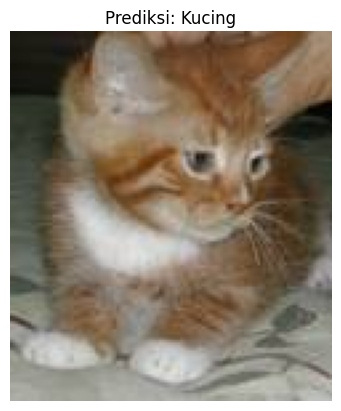

In [2]:
# Dataset class
class KucingAnjingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        self.images = []
        for label, subdir in enumerate(['cats', 'dogs']):
            path = os.path.join(root_dir, subdir)
            for filename in os.listdir(path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append((os.path.join(path, filename), label))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Load model
def load_model(model_path):
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Prediksi gambar
def predict_image(img_path, model):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(img_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    output = model(image_tensor)
    _, predicted = torch.max(output, 1)
    label = 'Kucing' if predicted.item() == 0 else 'Anjing'

    plt.imshow(image)
    plt.title(f'Prediksi: {label}')
    plt.axis('off')
    plt.show()

# Training function
def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = KucingAnjingDataset(root_dir='/kaggle/input/cat-and-dog/training_set/training_set')
    train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(5):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

    torch.save(model.state_dict(), 'cat_dog_checkpoint.pth')

# Main
if __name__ == "__main__":
    train_model()
    model = load_model("cat_dog_checkpoint.pth")
    predict_image("/kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4029.jpg", model)  